# Decision Trees & Random Forests

Have a look at [Chapter 5.08 of PDSH on Decision Trees and Random Forests](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)[![Cover image of PDSH](images/PDSH-cover-small.png)](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)

I think decision trees should be familiar to many of you in the form of identification keys: a series of questions to narrow in on a classification. Each question typically has two answers, each leading to another question, narrowing in on a classification. Even the image from PDSH is reminiscent of a key, taking the task of classifying an animal found on a hike:

![Decision tree image from Python Data Science Handbook](images/05.08-decision-tree.png)

In efficient decision trees, each question with halve the number of possibilities and decision trees can be an efficient method for classification.



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
#import plotnine as pn
import matplotlib.pyplot as plt
import graphviz

import helpers_05_08 # A set of visualization helpers from PDSH text

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn import metrics


In [3]:
# Generate some blobs of data
X, y = make_blobs(n_samples=300, centers=4, #make blobs is a random generator
                  random_state=0, cluster_std=1.0)

# If you want to do in plotnine:
df=pd.DataFrame({'X[0]':X[:,0], 'X[1]':X[:,1], 'y':y } )
#pn.ggplot(df, pn.aes(x='X[0]', y='X[1]')) + pn.geom_point(pn.aes(color='factor(df.y)'))

# If you want to do as in text with plt:
#plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

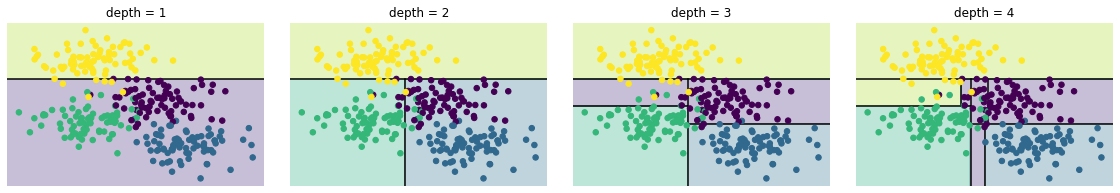

In [4]:
# Make decision trees of depth 1-4 plotting each        
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

for axi, depth in zip(ax, range(1, 5)):
    model =DecisionTreeClassifier(max_depth=depth)
    helpers_05_08.visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth)) # below are values going one layer deep or one node depth is one value

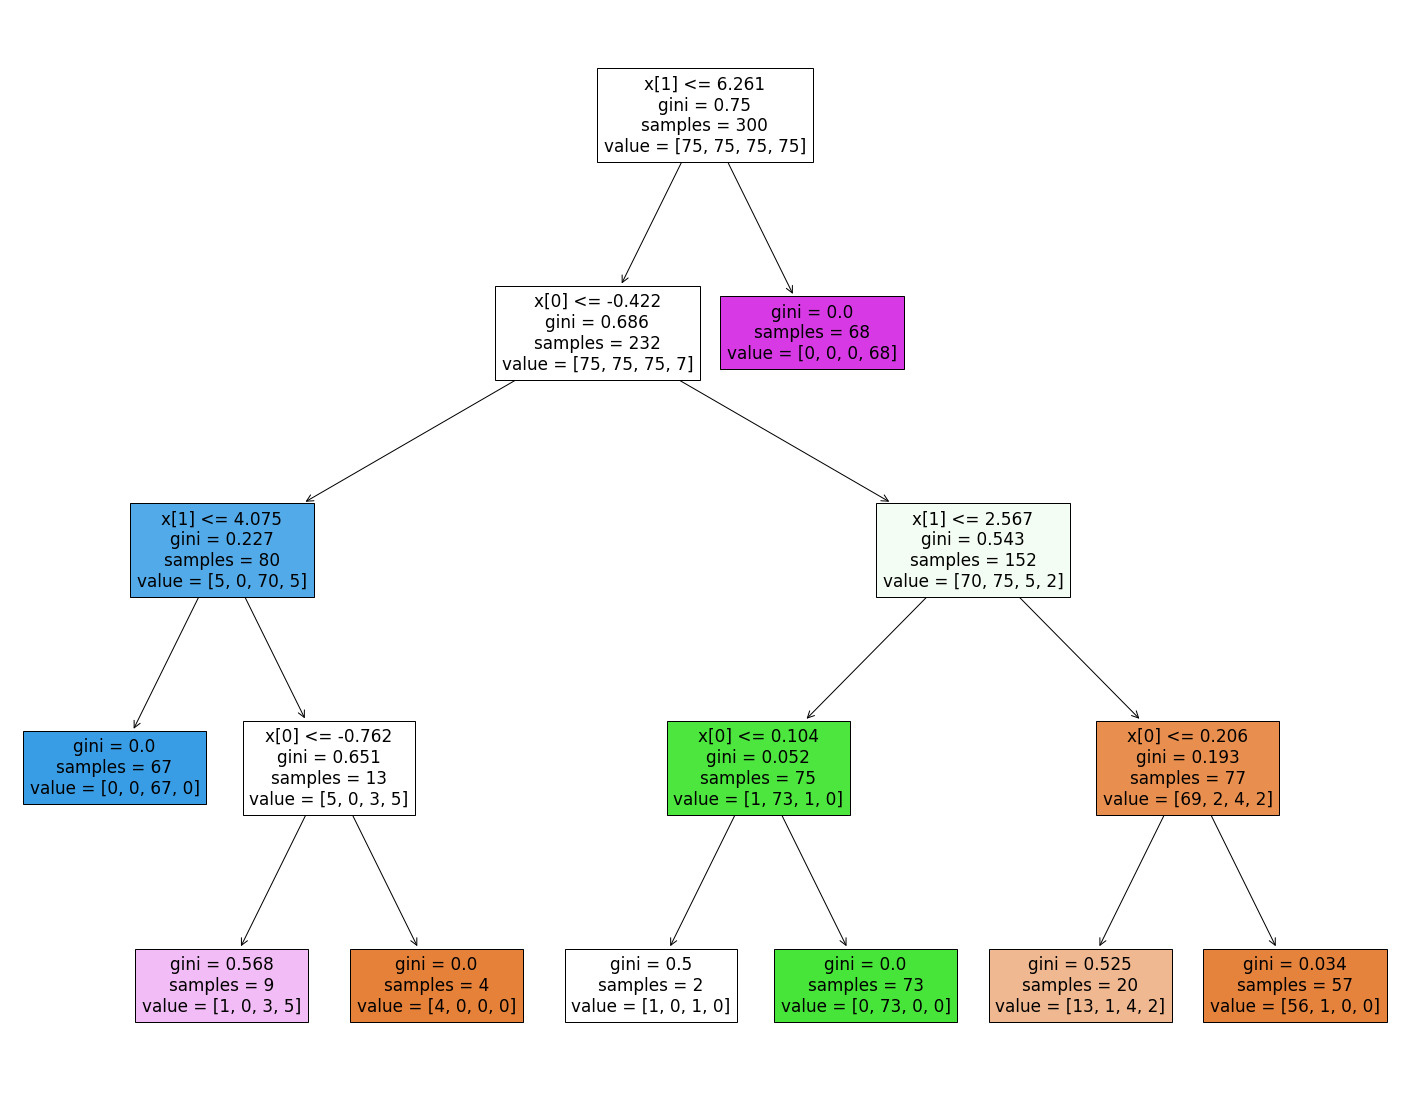

In [5]:
# Visualize the depth 4 tree using plot_tree
fig = plt.figure(figsize=(25,20))
annotations = plot_tree(model, filled=True) # Assign text annotations to variable to not print

## A closer look at the nodes and leaves of the decision tree

Let's take a look at the information presented in the tree. Here's the first node:

![First node in the decision tree](images/decision_tree_node.png)

The `X[1] <= 6.261` shows that the first node splits samples based on the second data column (`X[1]`), and samples that are less than or equal to 6.261 are split to the left and those greater are split to the right.

The `gini = 0.75` is the Gini index, a measure of entropy or how much noise a node has.

The `samples = 300` indicates that all 300 of our samples are at this node (we haven't split anything yet).

And the `value = [75,75,75,75]` is the number of each of the four classes at this node (again all 300 samples).

Looking at the split to the right, we see a leaf, since it's at the tip of the tree:

![Second node in the decision tree](images/decision_tree_node2.png)

The gini is 0 since all of the samples are the fourth class. The node is dark purple, the color selected to represent the fourth class, and there are 68 of the 75 class four samples in assigned using the split above.

You can work your way through the tree seeing the data that was used to make each split, the gini value at each split and the number of samples and their categories at each step.

## Visualizing the classification of the decision tree

In [55]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'): # in the white both the features ar organize din order of importance
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

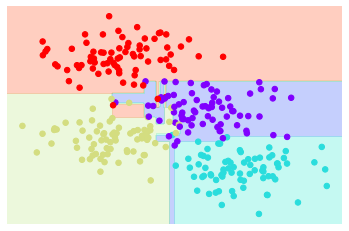

In [56]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [7]:
# Script from: Python Data Science Handbook
# Script by: Jake Vanderplas
# Source: https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/helpers_05_08.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

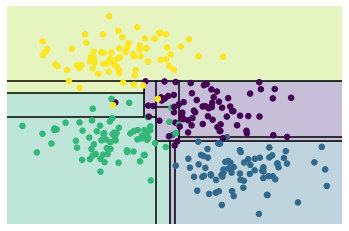

In [8]:
# helpers_05_08 is found in the online appendix

helpers_05_08.plot_tree_interactive(X, y);

As the text notes, one of the issues with decision trees is overfitting.

We've looked at overfitting before, and one way to see this is to compare models trained on different portions of the data. We could take random splits of the data, but the text takes a simpler approach, taking every other element of the dataset starting at 0, for one model and starting at 1 for the other model and then comparing the plots of each.

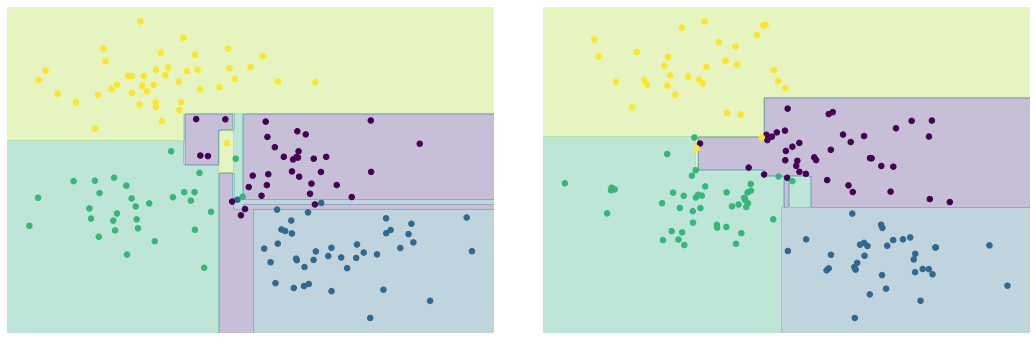

In [58]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
helpers_05_08.visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
helpers_05_08.visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])


## An example and some more details of Decision Trees

After the above, the PDSH text more or less says, one issue of decision trees is overfitting and the solution to that is the ensemble random forest method that we will come back to. 

This misses some important tools that we will cover with this example looking at classifying wine quality based on a number of characteristics.

The data are from [Kaggle: Red Wine Quality](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) originally published by Cortez et al., 2009.

The classification is 'quality' a subjective score that ranges from 3-8 (at least in our datasets). For classification, let's simplify this and say that a **score of 6 or higher is good wine (1), while a score of 5 or lower is bad(0)**. Note that decision trees can also be used in regression, and much of the following will work with `DecisionTreeRegressor`.

In [10]:
# Load the data

df= pd.read_csv('/blue_bsc4892/share/Jupyter_Content/data/winequality-red.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: '/blue_bsc4892/share/Jupyter_Content/data/winequality-red.csv'

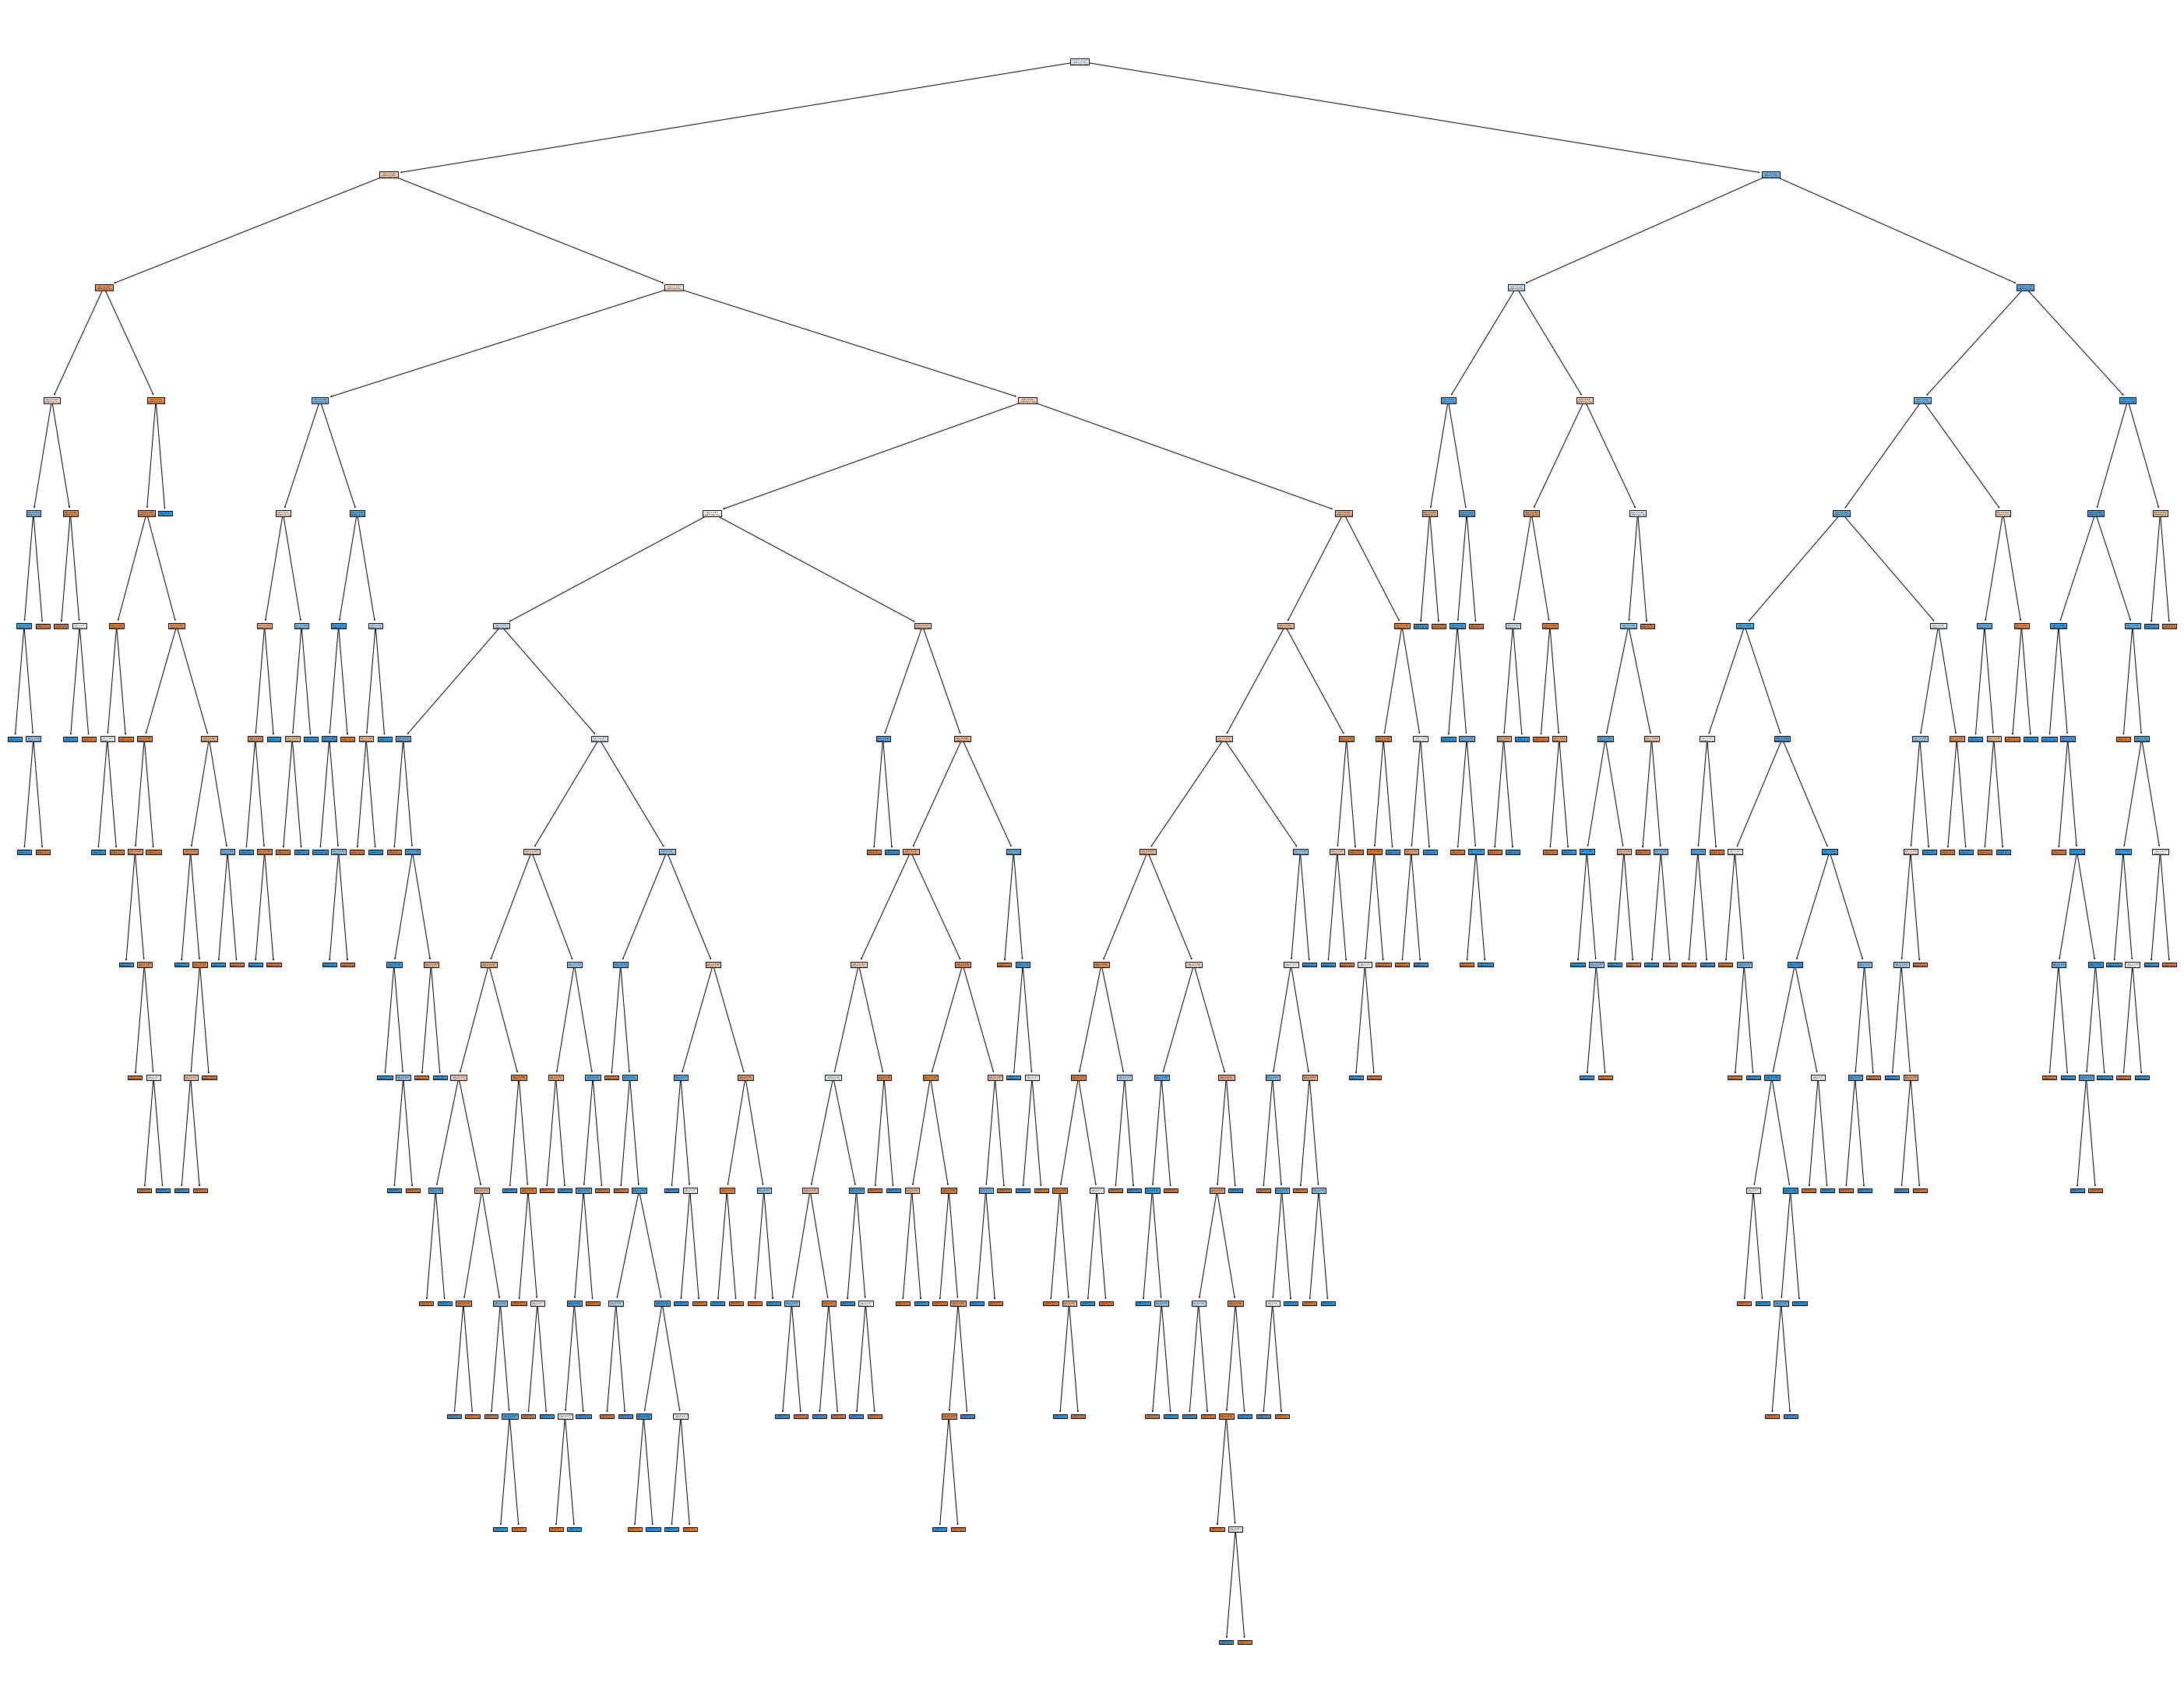

In [60]:
X = df.drop(columns='quality')
y = df['quality'].apply(lambda y_data: 1 if y_data>=6 else 0) # Transform the data to Good (6+) and bad (<6) wines.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model =Pipeline([ 
    #('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier())
])
model.fit(X_train, y_train)

# Visualize the dept 4 tree using plot_tree
fig = plt.figure(figsize=(50,40))
annotations = plot_tree(model['tree'], filled=True) # Assign text annotations to variable to not print

In [61]:
# Get accuracy
print(f'Train Accuracy: {accuracy_score( model.predict(X_train),y_train)}')
print(f'Test Accuracy: {accuracy_score( model.predict(X_test),y_test)}')

Train Accuracy: 1.0
Test Accuracy: 0.73125


### Cost Complexity Pruning, Post Pruning

As we've seen the model is overfitting the training data, getting 100% accuracy on the training data and only 72% on the testing data. Tree is also quite large, but how deep should we make our tree?

Cost Complexity Pruning can be used to select a best value by optimizing the trade off between trees that are too deep and over fit and trees that are too shallow and under fit (the bias-variance trade off returns!).

For each tree, we can calculate a tree score. Essentially we can use a measure analogous to the $MSE$ to estimate how well a tree fits the data. The largest, deepest tree will have the lowest score. But we can also construct a score that penalizes deeper trees, essentially:

$$ Tree\,score = MSE + (\alpha * Number\,of\,leaves\,in\,tree) $$

Where $\alpha$ is the **cost complexity score**.

Cost complexity pruning is a post pruning method because the way it works is to start with the full tree, then find an $\alpha$ that would favor the tree with one less leaf. Then repeat this until you get down to the single leaf tree (all samples are in one category). Then evaluate models and find the best $\alpha$.

#### Step 1:
Calculate the alphas, one for each tree starting with the full tree and finding an alpha where the tree score using that $\alpha$ would select the next smallest tree 

In [62]:
# Calculate the alphas

path = model['tree'].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00071492 0.00074471 0.00078195 0.00078195 0.00079436
 0.00080429 0.00081241 0.00083408 0.00083408 0.00084401 0.00084401
 0.0008511  0.00085303 0.0008548  0.00086174 0.00086451 0.00086883
 0.00087238 0.00087969 0.00089366 0.00091576 0.00096594 0.00106388
 0.00112345 0.00119154 0.00119154 0.00119154 0.00119154 0.00119154
 0.00119154 0.00119154 0.00121282 0.00125306 0.00125537 0.00127098
 0.00134048 0.00134048 0.00134048 0.00134048 0.00134048 0.00134048
 0.00136176 0.00137378 0.00143435 0.00146651 0.00148943 0.00148943
 0.00148943 0.00148943 0.00150326 0.00151033 0.00153198 0.0015639
 0.0015639  0.00156789 0.00158872 0.00158872 0.001604   0.00160858
 0.00163837 0.00163837 0.00164373 0.00165965 0.0016636  0.00166405
 0.00166816 0.00167103 0.00171639 0.00172348 0.001767   0.00179795
 0.00182987 0.00193533 0.00194685 0.0019713  0.00199115 0.0020628
 0.00207037 0.0020852  0.00209131 0.00218945 0.00233131 0.00241287
 0.00245609 0.00248946 0.00252629 0.0025533  0.0025942  0.002673

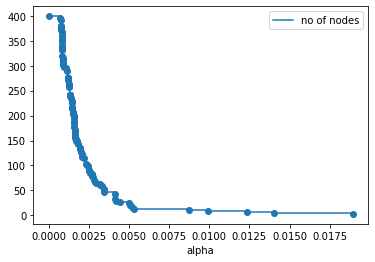

In [63]:
# For each alpha we will append our model to a list # as we increase the alpha value the pentaly increases 
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]

plt.scatter(ccp_alphas,node_counts)
plt.xlabel("alpha")

plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")

plt.legend()
plt.show()

#### Step 2: Select and $\alpha$

Now we can take those $\alpha$ values and compare the test and train accuracy at each alpha and select the one with the highest training accuracy.

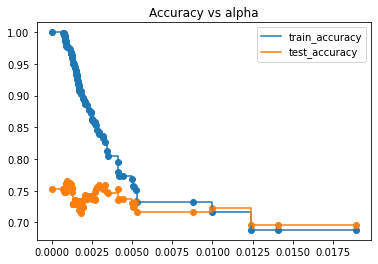

Best accuracy of 0.7645833333333333 obtained at alpha 0.0009659359722441248


In [64]:
train_acc = []
test_acc = []
best_acc=0
best_alpha=0
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))
    if accuracy_score(y_test_pred,y_test) > best_acc:
        best_acc=accuracy_score(y_test_pred,y_test)
        best_alpha=c.ccp_alpha

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()
print(f'Best accuracy of {best_acc} obtained at alpha {best_alpha}')

We can then use that $\alpha$ value:

In [65]:
clf_ = DecisionTreeClassifier(ccp_alpha=best_alpha)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')


Train score 0.9767649687220733
Test score 0.7666666666666667


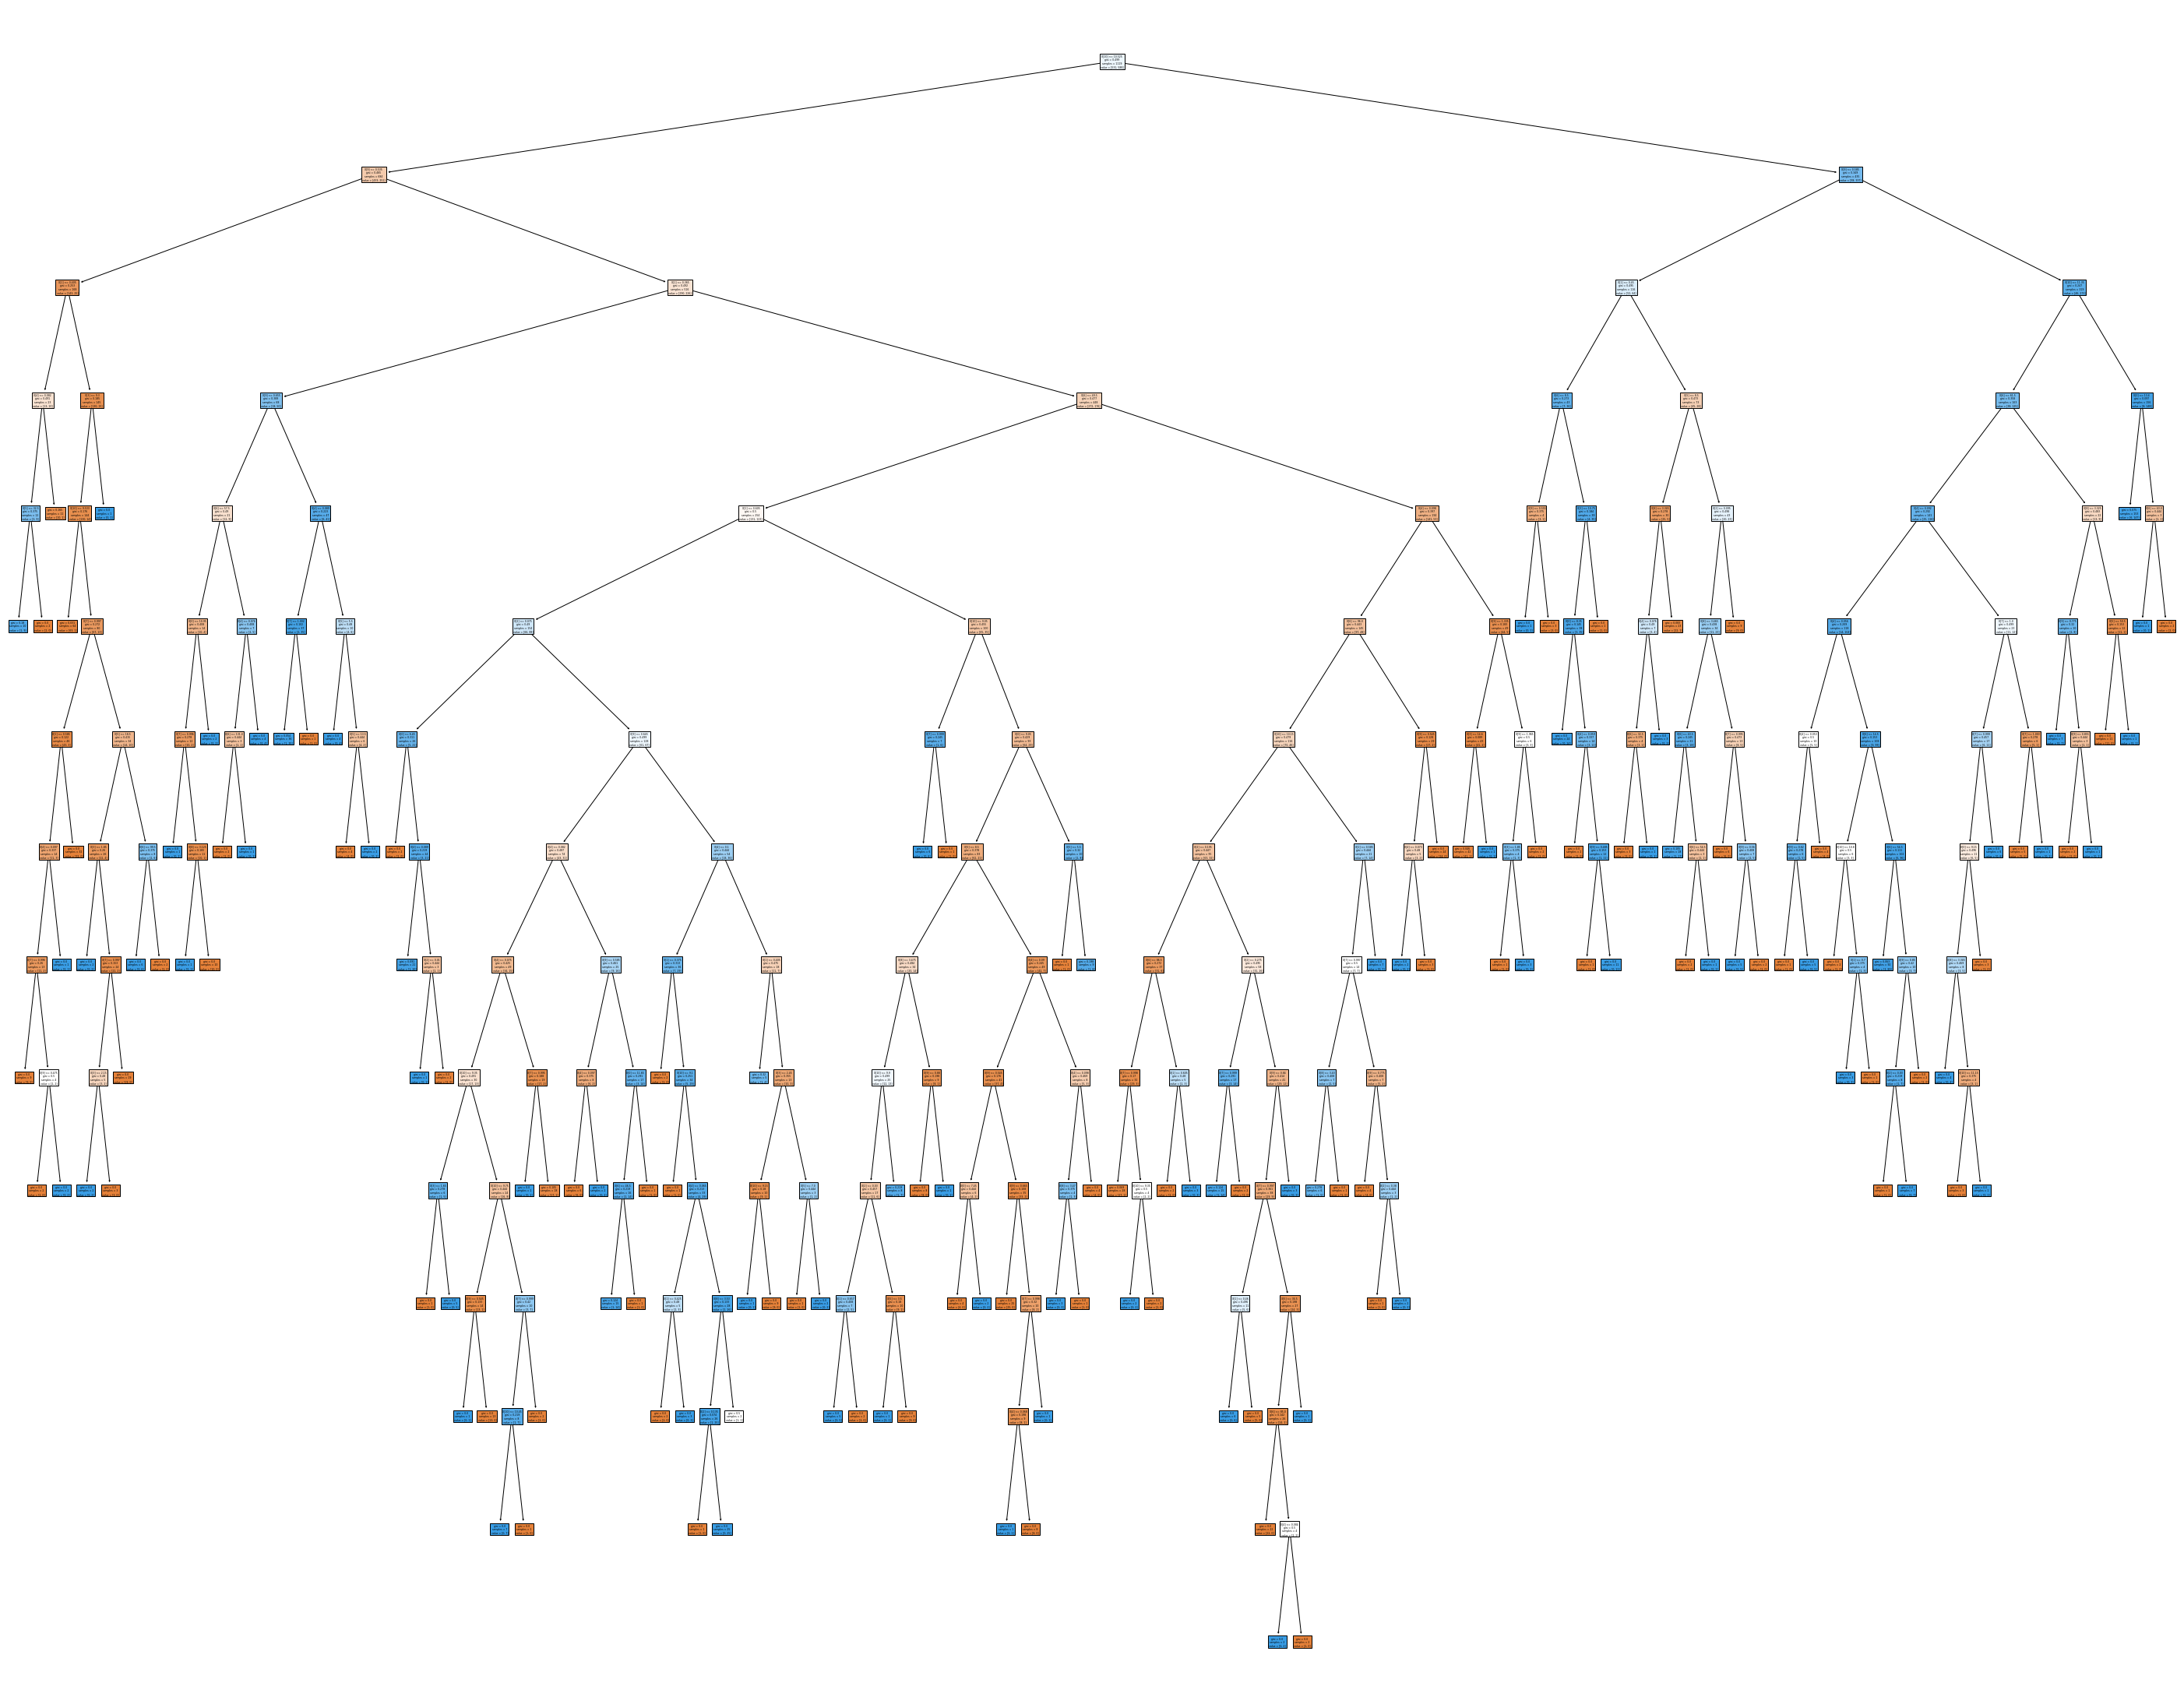

In [66]:
fig = plt.figure(figsize=(50,40))
annotations = plot_tree(clf_, filled=True) # Assign text annotations to variable to not print

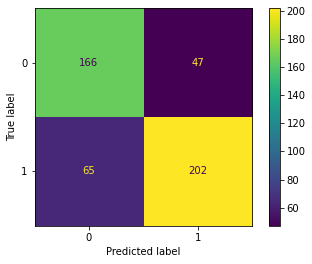

In [67]:
cm = confusion_matrix(y_test, y_test_pred)
# Plot the confusion matrix
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()

### Tuning other parameters, Pre pruning

We can also make *a priori* decisions on the depth and other measures to prune the tree before making it:

Other parameters to tune are:
 * `max_depth`: The maximum depth of the tree
 * `min_samples_split`: The minimum number of samples required to split an internal node
 * `min_samples_leaf`: The minimum number of samples required to be at a leaf node
 
 Luckily, GridSearchCV can still be used here:


In [68]:
# Tune other parameters
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2],
         'ccp_alpha': [0.00134]}

clf = DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(X_train,y_train)
print(gcv.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.00134, max_depth=12, min_samples_leaf=2)


Train score 0.9392314566577301
Test score 0.7166666666666667


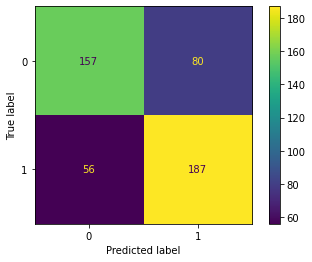

In [69]:
model = gcv.best_estimator_
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test_pred,y_test), display_labels=[0,1]).plot()

## Ensembles of Estimators: Random Forests

The interesting thing here is that if we take a bunch of over fit models and combine them, we can actually get a reasonable estimate. This is referred to as an **ensemble method** called **bagging**. From PDSH:

> Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a *random forest*.

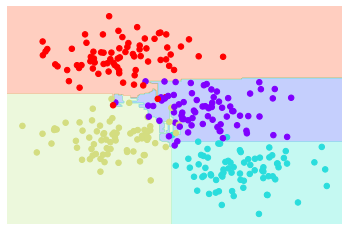

In [70]:
# Generate some blobs of data
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, 3 100 decision trees made with 80% of the data
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

Again  from PDSH:
> In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. For example, when determining which feature to split on, the randomized tree might select from among the top several features. You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

Take note of the bias variance tradeoff discussion in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#forest)--sound familiar??

The `RandomForestClassifier` selects samples from the training set with replacement (bootstrapping). Either all or a random subset of features are used for each split.

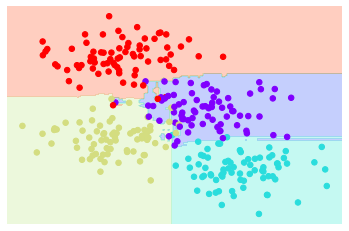

In [71]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## Random Forest Regression

I'm not going to cover, this, but check out the text if you want information on how Random Forests can also be used for regression problems.



## Example: Random Forest for Classifying Digits

Back to the digits dataset we looked at [earlier using naive Bayes](07_Intro_sklearn_student.ipynb) (note that we got about 83% accuracy then). Again this is a set of 1,797 scans of hand written digits, each digit is a 8X8 pixel grey-scale image.

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


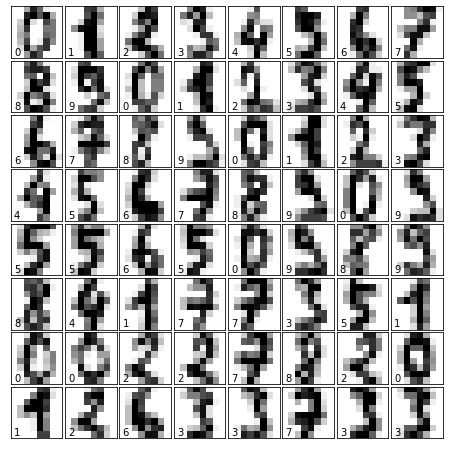

In [72]:

digits = load_digits()
print(digits.keys())

# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [73]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [74]:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



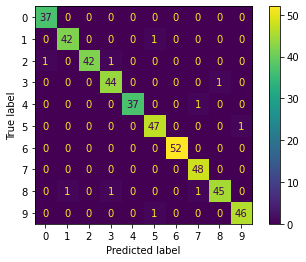

In [75]:
from sklearn.metrics import confusion_matrix
cm = metrics.confusion_matrix(ytest, ypred)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=digits.target_names).plot()